In [52]:
import sys
sys.path.append("../src/")
from modeling.utils.data import *
import os
from modeling.utils.models import *
from modeling.utils.plotting import *

In [2]:
#### Parameters
path = "P:\CH\Weather Data\ERA-5\GEOPOTENTIAL"
file = "ERA-5_hourly_Geopotential-500hPa_1-24Nov2021.nc"
file_normal = "ERA-5_daily_Geopotential-500hPa_DecJanFeb_1979-2020_normal.nc"

### 1 - Loading Data

In [3]:
### Conversion Hourly -> Daily
file_inf = read_nc(os.path.join(path,file))
file_inf_daily = hourly_to_daily(file_inf)
file_inf_daily = limit_geography(file_inf_daily, LAT, LONG)
file_inf_daily /= G

	func:'read_nc' took: 0.0838 sec
	func:'hourly_to_daily' took: 3.1655 sec
	func:'limit_geography' took: 0.0399 sec


In [4]:
# Writing Daily File into P
file_inf_daily.to_netcdf(path + '/ERA-5_{}_{}_{}{}.nc'. \
                 format('daily', 'Geopotential-500hPa', '1-24Nov', '2021'),
                 engine="netcdf4")

In [4]:
# Read Normal File
z_normal = read_nc(os.path.join(path,file_normal))
z_normal

	func:'read_nc' took: 0.0618 sec


<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 481)
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 -89.25 ... 29.5 29.75 30.0
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... 20.5 20.25 20.0
Data variables:
    z          (latitude, longitude) float32 ...

In [6]:
# Writing Anomaly Z500 daily file
z_normal.to_netcdf(path + '/ERA-5_{}_{}_{}{}_{}.nc'. \
                 format('daily', 'Geopotential-500hPa', '1-24Nov', '2021', 'normal'),
                 engine="netcdf4")

In [5]:
z_anomaly = file_inf_daily - z_normal

In [6]:
z_anomaly = weighted_anomaly(z_anomaly)

	func:'weighted_anomaly' took: 0.0209 sec


In [9]:
# Writing Anomaly Z500 daily file
z_anomaly.to_netcdf(path + '/ERA-5_{}_{}_{}{}_{}.nc'. \
                 format('daily', 'Geopotential-500hPa', '1-24Nov', '2021', 'anomaly'),
                 engine="netcdf4")

### 2 - Dimensionality Reduction

In [7]:
# Flat the array (from 3D to 2D)
pivot_anomaly = flat_table(z_anomaly)

	func:'flat_table' took: 0.0110 sec


In [8]:
reduced_pca = reduce_dim(pivot_anomaly,method="PCA",exp_variance=15)

Number of days: 24, Density of the grid: 15 cells
	func:'reduce_dim' took: 0.3032 sec


In [9]:
reduced_vae = reduce_dim(z_anomaly,method="VAE",season="WINTER",model="sigma_vae_statedict_5")

Processing batch 1Number of days: 24, Density of the grid: 5 cells
	func:'reduce_dim' took: 4.9777 sec


### 3 - Inference

#### 3.1 - Inference with PCA

In [53]:
### Load Models
model = load_estimator("../models/WINTER/pca/kmeans_model_ch.pkl")

# labels_text = {0: "SB", 1: "NAO-", 2: "NAO+", 3: "AR"} 

In [51]:
# Probleme avec l'attribution des regimes : une solution serait de faire le lien entre #model.cluster_centers_ du pkl

array([[-1.34847879e+04,  5.67560381e+03,  1.13175037e+03,
        -3.75375629e+02,  5.38867495e+02,  3.60337063e+02,
        -7.11274498e+02, -4.56039271e+02, -2.88889142e+02,
         7.36668763e+01, -2.56800575e+02, -1.16668612e+02,
         1.07691106e+02,  3.94704941e+02,  9.55499767e+01],
       [ 7.21304227e+03,  8.72209259e+02, -1.34772901e+04,
        -2.92801957e+03,  4.35081845e+02, -8.41631883e+02,
        -6.74424586e+02,  6.29095648e+00,  1.65586833e+02,
        -7.49489441e+02, -1.92109476e+02, -5.53041459e+01,
        -3.86628439e+02,  2.92191659e+02, -1.77208244e+01],
       [-1.10890679e+03, -1.34557544e+04,  3.65693212e+03,
         1.91548888e+03,  2.81751686e+02,  2.04452311e+02,
         9.02378661e+02,  3.13260321e+02,  4.52304286e+02,
         1.61269269e+01,  2.50650391e+02,  2.87869516e+02,
        -1.20464736e+02, -4.32310602e+02, -7.83633561e+01],
       [ 1.60821205e+04,  7.79886174e+03,  7.95613704e+03,
         1.08120702e+03, -2.24403216e+03,  1.70437387

In [54]:
reduced_pca.shape

(24, 15)

In [55]:
reduced_pca = np.array(reduced_pca,dtype=np.double)
pca_inference = model.predict(reduced_pca)

In [12]:
pca_inference

array([3, 3, 3, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 1])

In [37]:
pca_inference

array([3, 3, 3, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 1])

In [38]:
pca_inference_onehot = np.zeros((pca_inference.size, pca_inference.max()+1))
pca_inference_onehot[np.arange(pca_inference.size),pca_inference] = 1

<AxesSubplot:>

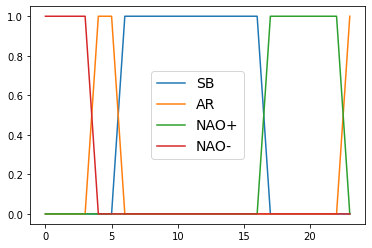

In [56]:
df = pd.DataFrame(pca_inference_onehot)
df.rename(columns =  {0: "SB", 1: "AR", 2: "NAO+", 3: "NAO-"}, inplace = True)
df.plot(kind='line')

In [46]:
reduced_pca.dtype

dtype('float64')

In [57]:
### Plot Centroids
outputs= extract_regimes(reduced_pca,method="kmeans",nb_regimes=None, estimator=model)

In [58]:
outputs

(array([3, 3, 3, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
        2, 1]),
 2117046693293.1777,
 KMeans(init='random', n_clusters=4, random_state=42, tol=0.001))

In [23]:
labels,inertias, _ = outputs

In [24]:
labels

array([3, 3, 3, 3, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 1])

In [59]:
labels_text = {0: "SB", 1: "AR", 2: "NAO+", 3: "NAO-"} 
labels = list(map(lambda x: labels_text[x], labels))

In [60]:
labels

['NAO-',
 'NAO-',
 'NAO-',
 'NAO-',
 'AR',
 'AR',
 'SB',
 'SB',
 'SB',
 'SB',
 'SB',
 'SB',
 'SB',
 'SB',
 'SB',
 'SB',
 'SB',
 'NAO+',
 'NAO+',
 'NAO+',
 'NAO+',
 'NAO+',
 'NAO+',
 'AR']

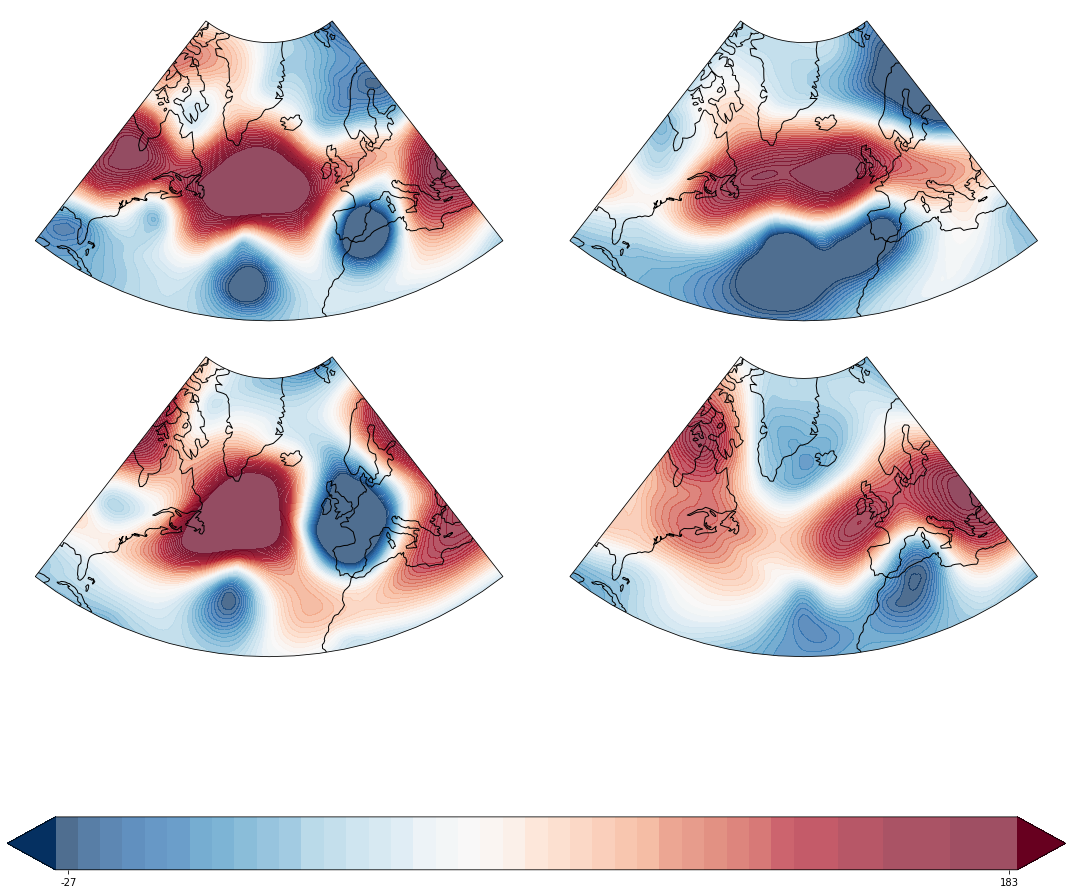

In [61]:
plot_regimes(pivot_anomaly,labels)

#### 3.2 - Inference with VAE

In [18]:
### Load Bayesian GMM Models
model_vae = load_estimator("../models/WINTER/vae/bayesian_gmm_model_bic.pkl")

# BIC : labels_text = {0: "AR", 1: "NAO-", 2: "NAO+", 3: "SB"}

<AxesSubplot:>

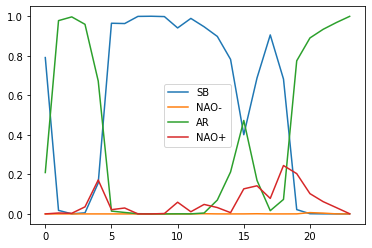

In [30]:
df = pd.DataFrame(model_vae.predict_proba(reduced_vae))
df.rename(columns =  {0: "SB", 1: "NAO-", 2: "AR", 3: "NAO+"}, inplace = True)
df.plot(kind='line')

<AxesSubplot:>

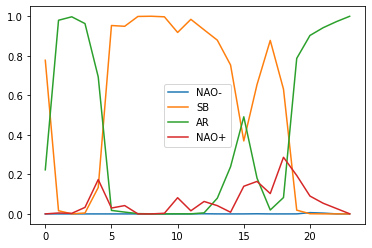

In [31]:
### Load GMM Models
model_vae_gmm = load_estimator("../models/WINTER/vae/gmm_model_ch.pkl")

# gmm ch : labels_text = {0: "NAO+", 1: "NAO-", 2: "AR", 3: "SB"} 

df = pd.DataFrame(model_vae_gmm.predict_proba(reduced_vae))
df.rename(columns =  {0: "NAO-", 1: "SB", 2: "AR", 3: "NAO+"}, inplace = True)
df.plot(kind='line')